In [4]:

import pandas
import os
from metric_utils import *
import torch
import ast
import numpy as np
from swarm_visualizer.boxplot import  plot_paired_boxplot
from swarm_visualizer.utility.general_utils import save_fig, set_plot_properties
from matplotlib import pyplot as plt
import warnings
import seaborn as sns
from seaborn import lineplot,scatterplot
warnings.filterwarnings('ignore')
from prettytable import PrettyTable

## Load the data

condition
Clear, Dawn/Dusk     0.010714
Clear, Day           0.686143
Clear, Night         0.018429
Cloudy, Dawn/Dusk    0.002857
Cloudy, Day          0.040429
Cloudy, Night        0.001714
Rainy, Dawn/Dusk     0.002714
Rainy, Day           0.216143
Rainy, Night         0.020857
dtype: float64
condition
Clear, Dawn/Dusk     0.011
Clear, Day           0.764
Clear, Night         0.014
Cloudy, Dawn/Dusk    0.002
Cloudy, Day          0.025
Cloudy, Night        0.001
Rainy, Dawn/Dusk     0.006
Rainy, Day           0.157
Rainy, Night         0.020
dtype: float64


Text(0, 0.5, 'Number of Samples')

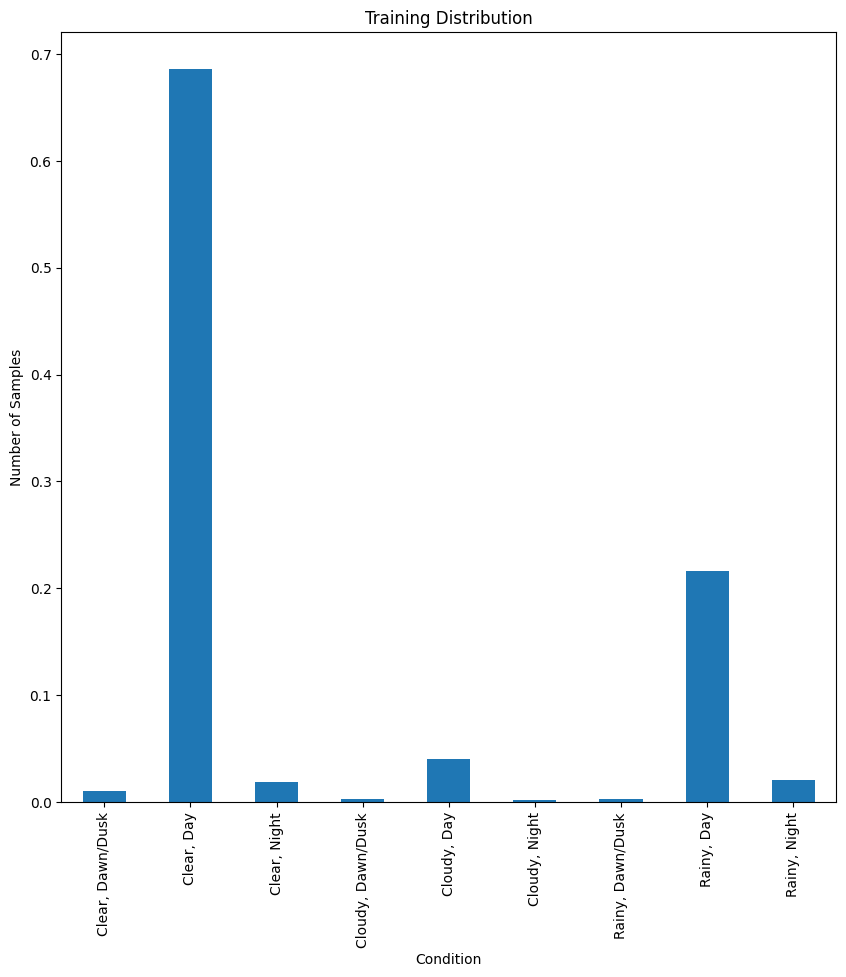

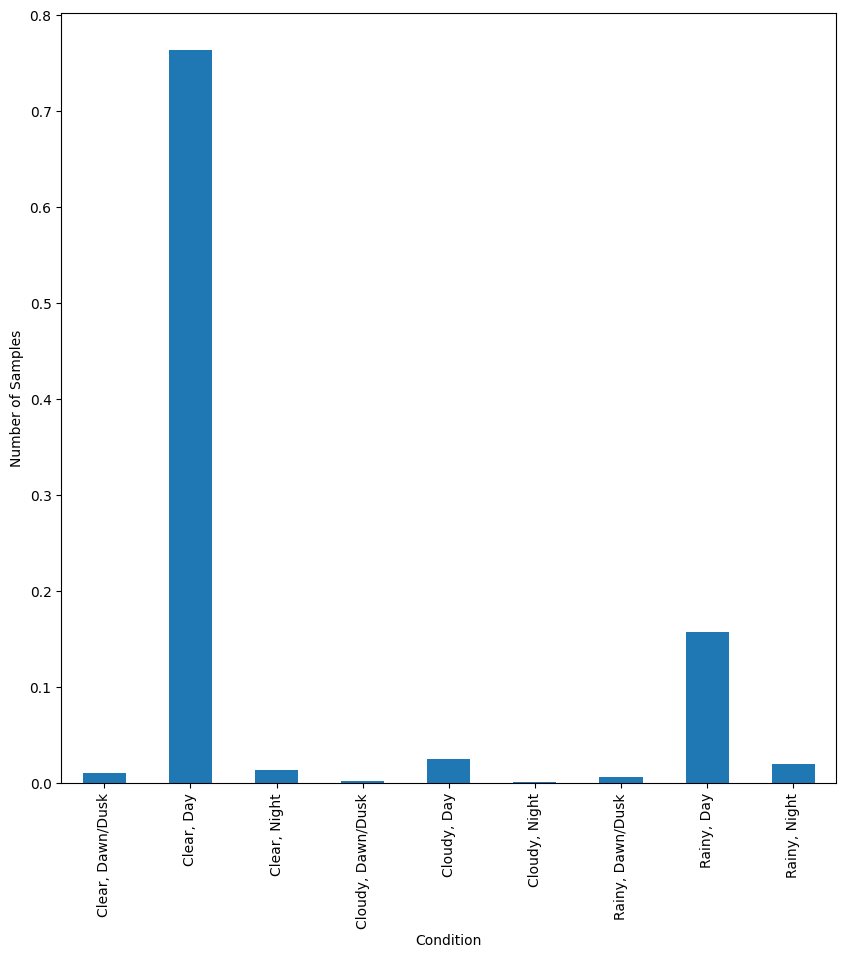

In [2]:
# Training Distribution Plots

TRAIN_FILENAME = '../../bdd100k/metadata_train_seg.csv'
TEST_FILENAME = '../../bdd100k/metadata_val_seg.csv'

train_df = pandas.read_csv(TRAIN_FILENAME)
plt.figure(figsize=(10, 10))
df = train_df.groupby('condition').size()/train_df.shape[0]
print(df)
df.plot(kind='bar')

plt.xlabel('Condition')
plt.ylabel('Number of Samples')
plt.title('Training Distribution')
plt.figure(figsize=(10, 10))
val_df = pandas.read_csv(TEST_FILENAME)
df = val_df.groupby('condition').size()/val_df.shape[0]
print(df)
df.plot(kind='bar')
plt.xlabel('Condition')
plt.ylabel('Number of Samples')


In [3]:
FOLDER = '../tests/'
files = os.listdir(FOLDER)
PALLETE = {
            "undefined": [0, 0, 0],
            "road": [128, 64, 128],
            "sidewalk": [244, 35, 232],
            "building": [70, 70, 70],
            "wall": [190, 153, 153],
            "fence": [102, 102, 156],
            "pole": [153, 153, 153],
            "traffic light": [250, 170, 30],
            "traffic sign": [220, 220, 0],
            "vegetation": [107, 142, 35],
            "terrain": [152, 251, 152],
            "sky": [70, 130, 180],
            "person": [220, 20, 60],
            "rider": [255, 0, 0],
            "car": [0, 0, 142],
            "truck": [0, 0, 70],
            "bus": [0, 60, 100],
            "train": [0, 80, 100],
            "motorcycle": [0, 0, 230],
            "bicycle": [119, 11, 32]
        }
CLASSES = np.array(list(PALLETE.keys()))
COMPUTE_CLASSES = np.arange(len(CLASSES))[1:]
print(CLASSES[COMPUTE_CLASSES])


['road' 'sidewalk' 'building' 'wall' 'fence' 'pole' 'traffic light'
 'traffic sign' 'vegetation' 'terrain' 'sky' 'person' 'rider' 'car'
 'truck' 'bus' 'train' 'motorcycle' 'bicycle']


## Compile Data

In [5]:
MODEL_DATA= dict()
for file in files:
    if file.endswith('.csv') and 'bdd' in file:
        model = file.split('.')[0]
        df = pandas.read_csv(FOLDER + file)
        # Convert each relevant column to a Torch tensor
        MODEL_DATA[model] = df
        # print(len(df))
        # print(df.groupby('condition').size())
        # barplot
        print(model)
        df.groupby('condition').size().plot(kind='bar')
    
def string_to_tensor(tensor_string):
    # Convert string representation of a tensor to an actual tensor
    # Use ast.literal_eval to safely evaluate the string
    #print(tensor_string.strip("[]").split())
    array_list = [float(item) for item in tensor_string.strip("[]").split()]

    # Convert the list to a NumPy array
    np_array = np.array(array_list)

    # Convert the NumPy array to a PyTorch tensor
    tensor = torch.tensor(np_array)
    return tensor

def stack_sum_tensors(series):
    return torch.stack(series, dim=0).sum(dim=0).detach().cpu().numpy()

def mean_metrics(series, class_idx):
    #ignore nans when computing the mean
    
    series[np.isinf(series)] = np.nan
    #print(series[class_idx])
    return np.nanmean(series[class_idx]).item()

def std_metrics(series, class_idx):
    #ignore nans when computing the mean
    series[np.isinf(series)] = np.nan
    return np.nanstd(series[class_idx]).item()

def accumulate(series):
    #ignore nans when computing the mean
    series[np.isinf(series)] = np.nan
    #print(series)
    #Only return the series for class_idx and non nan values
    return series.tolist()

def per_class_metrics(df_dict):
    
    # convert data frame to dictionary where keys are the metrics and the values are a list
    # of numbers corresponding to the performance of each class
    
    #df_dict = df.to_dict(orient='list')
    # For each class compute log the mean metrics
    ret_metrics_class = OrderedDict({
        ret_metric: np.round(ret_metric_value * 100, 2)
        for ret_metric, ret_metric_value in df_dict.items()
    })
    
    class_table_data = PrettyTable()


    ret_metrics_class.update({'Class': WAYMO_CLASSES})
    ret_metrics_class.move_to_end('Class', last=False)

    for key, val in ret_metrics_class.items():
        class_table_data.add_column(key, val)

    print('per class results:\n')
    print('\n' + class_table_data.get_string())

In [6]:
warnings.filterwarnings('always')
avg_metrics_df = pandas.DataFrame(columns=['model','condition', 'accuracy', 'IoU', 'Dice', 'F1'])
avg_metrics_df['model'] = MODEL_DATA.keys()
tensor_columns = ['mIoU_intersect', 'mIoU_union', 'mIoU_pred_label', 'mIoU_label'] 
metrics_column = ['accuracy', 'IoU', 'Dice', 'F1']
avg_metrics_col = ['mAcc','mIoU', 'mDice', 'mF1']

data_plot = dict()
avg_data_plot = dict()
for model, data in MODEL_DATA.items():
    print('RESULTS FOR MODEL: ', model)
    metrics_df = pandas.DataFrame(columns=['condition', 'accuracy', 'IoU', 'Dice', 'F1'])
    # List of tensor columns

    # Convert tensor columns from string to actual tensors
    for col in tensor_columns:
        data[col] = data[col].apply(string_to_tensor)
    
    # Compute mIoU, mAcc, mDice, mF1 across all conditions
    data_avg_all = dict(
        mIoU_intersect=[],
        mIoU_union=[],
        mIoU_pred_label=[],
        mIoU_label=[]
    )
    data_avg_all['mIoU_intersect'] = torch.stack(list(data['mIoU_intersect'].copy()), dim=0).sum(dim=0).detach().cpu().numpy()
    data_avg_all['mIoU_union'] = torch.stack(list(data['mIoU_union'].copy()), dim=0).sum(dim=0).detach().cpu().numpy()
    data_avg_all['mIoU_pred_label'] = torch.stack(list(data['mIoU_pred_label'].copy()), dim=0).sum(dim=0).detach().cpu().numpy()
    data_avg_all['mIoU_label'] = torch.stack(list(data['mIoU_label'].copy()), dim=0).sum(dim=0).detach().cpu().numpy()
        # Pretty Table for per class metrics

    
    # for key, value in data_avg_all.items():
    #     print(data_avg_all[key].shape)
    #     print(data_avg_all[key])
    
    compiled_metrics = dict()
    
    compiled_metrics['mIoU'] = IoU = compute_IOU(data_avg_all['mIoU_intersect'], data_avg_all['mIoU_union'])
    compiled_metrics['mAcc'] = accuracy = compute_accuracy(data_avg_all['mIoU_intersect'], data_avg_all['mIoU_label'])
    compiled_metrics['mDice'] = Dice = compute_DICE(data_avg_all['mIoU_intersect'], data_avg_all['mIoU_union'])
    compiled_metrics['mF1'] = f1score = compute_F1(data_avg_all['mIoU_intersect'], data_avg_all['mIoU_pred_label'], data_avg_all['mIoU_label'])
    
    per_class_metrics(compiled_metrics)
    
    print('mIoU: ', np.nanmean(IoU).item())
    print('mAcc: ', np.nanmean(accuracy).item())
    print('mDice: ', np.nanmean(Dice).item())
    print('mF1: ', np.nanmean(f1score).item())
    
    
    grouped_data = data.groupby('condition')[tensor_columns]
    grouped_data = grouped_data.agg(list)
    num_items = grouped_data.applymap(len)
    grouped_sum = grouped_data.applymap(stack_sum_tensors)
    
    grouped_sum['accuracy'] = compute_accuracy(grouped_sum['mIoU_intersect'], grouped_sum['mIoU_label'])
    grouped_sum['IoU'] = compute_IOU(grouped_sum['mIoU_intersect'], grouped_sum['mIoU_union'])
    grouped_sum['Dice'] = compute_DICE(grouped_sum['mIoU_intersect'], grouped_sum['mIoU_union'])
    grouped_sum['F1'] = compute_F1(grouped_sum['mIoU_intersect'], grouped_sum['mIoU_pred_label'], grouped_sum['mIoU_label'])
    metrics_df = grouped_sum[metrics_column]
    
    metrics_df_post = metrics_df.copy()
    metrics_df_post['accuracy']= metrics_df['accuracy'].apply(accumulate)
    metrics_df_post['IoU'] = metrics_df['IoU'].apply(accumulate)
    metrics_df_post['Dice']= metrics_df['Dice'].apply(accumulate)
    metrics_df_post['F1']= metrics_df['F1'].apply(accumulate)
    data_plot[model] = metrics_df_post
    

    
    # Compute mean and std across all conditions
    metrics_df['mAcc'] = metrics_df['accuracy'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
    metrics_df['mIoU'] = metrics_df['IoU'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
    metrics_df['mDice'] = metrics_df['Dice'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
    metrics_df['mF1'] = metrics_df['F1'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
    metrics_df['stdAcc'] = metrics_df['accuracy'].apply(std_metrics, class_idx=COMPUTE_CLASSES)
    metrics_df['stdIoU'] = metrics_df['IoU'].apply(std_metrics, class_idx=COMPUTE_CLASSES)
    metrics_df['stdDice'] = metrics_df['Dice'].apply(std_metrics, class_idx=COMPUTE_CLASSES)
    metrics_df['stdF1'] = metrics_df['F1'].apply(std_metrics, class_idx=COMPUTE_CLASSES)
    avg_metrics_df = metrics_df[avg_metrics_col]
    avg_data_plot[model] = avg_metrics_df.copy()
    #print(avg_metrics_df)




## Plot performance of original models


In [ ]:
 # Formatting data plot items
original_data_plot = {}
for model, data_ in data_plot.items():
    print(model)
    if 'synth' not in model and 'mixed' not in model:
        data=data_.copy()
        data['model'] = model
        
        if 'mask2former_swin' in model:
            data['model_cat'] = 'Mask2Former Swin-T' 
        elif 'mask2former_r50' in model:
            data['model_cat'] = 'Mask2Former Resnet 50' 
        elif 'segformer' in model:
            data['model_cat'] = 'Segformer'
        # print(data.columns)
        # print(data.index)
        data.reset_index(inplace=True)
        print(data.index)
        print(data.columns)
        data['accuracy'] = data['accuracy'].apply(np.nanmean)
        data['IoU'] = data['IoU'].apply(np.nanmean)
        data['Dice'] = data['Dice'].apply(np.nanmean)
        data['F1'] = data['F1'].apply(np.nanmean)
        original_data_plot[model] = data
pallete = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
all_data_original = pd.concat([dfs for dfs in original_data_plot.values()], ignore_index=True)

In [ ]:
# Line plot of accuracy with respect to conditions
set_plot_properties(
    font_size= 25,
    legend_font_size = 20,
    xtick_label_size = 15,
    ytick_label_size = 20,
    markersize = 15,
    usetex = True,
)
# Creating a box plot for accuracy of each ltl_group, differentiated by model
fig, ax = plt.subplots(figsize=(15, 12))

lineplot(all_data_original,
                    x='condition',
                    y='IoU', 
                    hue='model_cat', 
                    palette=pallete,
                    ax=ax)
plt.legend(fontsize=20, loc='lower right')
plt.title('Mean IoU Across different environmental conditions', fontsize=25)
plt.ylabel('IoU', fontsize=25)
plt.xlabel('Conditions', fontsize=25)



## Print the per condition scores for all models

In [ ]:
# Formatting data plot items
original_data_plot_avg= {}
for model, data in avg_data_plot.items():
    print(model)


    data['model'] = model
    
    if 'mask2former_swin' in model:
        data['model_cat'] = 'Mask2Former Swin-T' 
    elif 'mask2former_r50' in model:
        data['model_cat'] = 'Mask2Former Resnet 50' 
    elif 'segformer' in model:
        data['model_cat'] = 'Segformer'
    # print(data.columns)
    # print(data.index)
    data.reset_index(inplace=True)
    print(data.index)
    print(data.columns)
    original_data_plot_avg[model] = data
pallete = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
all_data_original_avg = pd.concat([dfs for dfs in original_data_plot_avg.values()], ignore_index=True)

In [ ]:
# Print the average metrics across all conditions

# Pretty Table for per class metrics
MDOELS = ['Mask2Former Swin-T', 'Mask2Former Resnet 50', 'Segformer']
metrics_column = ['mAcc','mIoU', 'mDice', 'mF1']
avg_metrics_table_data_dict = { k:PrettyTable() for k in MDOELS}
for model, data_ in avg_data_plot.items():
    metrics = data_[metrics_column]
    model_cat = data_['model_cat'].unique()[0]
    
    if 'mixed' in model and 'ft' not in model:
        ret_metrics_cond = OrderedDict({
        ret_metric+'_mix': np.round(ret_metric_value * 100, 2)
        for ret_metric, ret_metric_value in metrics.items()
         })
    elif 'ft' in model:
        ret_metrics_cond = OrderedDict({
        ret_metric+'_ft': np.round(ret_metric_value * 100, 2)
        for ret_metric, ret_metric_value in metrics.items()
         })
    else:
        ret_metrics_cond = OrderedDict({
        ret_metric: np.round(ret_metric_value * 100, 2)
        for ret_metric, ret_metric_value in metrics.items()
         })
    ret_metrics_cond.update({'Condition': list(data_['condition'])})
    ret_metrics_cond.move_to_end('Condition', last=False)

    avg_metrics_table_data_dict[model_cat].title = model_cat
    for key, val in ret_metrics_cond.items():
        avg_metrics_table_data_dict[model_cat].add_column(key, val)
    
for model, table in avg_metrics_table_data_dict.items():
    print(table)
    print('\n')



## Plot performance of all trained models


In [ ]:
# Formatting data plot items
for model, data in data_plot.items():
    print(model)
    data['model'] = model
    # print(data.columns)
    # print(data.index)
    data.reset_index(inplace=True)

    if 'mask2former_swin' in model:
        data['model_cat'] = 'Mask2Former Swin-T' 
    elif 'mask2former_r50' in model:
        data['model_cat'] = 'Mask2Former Resnet 50' 
    elif 'segformer' in model:
        data['model_cat'] = 'Segformer'
    
    if 'synth' in model:
        data['dataset'] = 'Synthetic'
    elif 'mixed' in model and 'ft' not in model:
        data['dataset'] = 'Mixed'
    elif 'ft' in model:
        data['dataset'] = 'Fine-tuned Synthetic'
    else:
        data['dataset'] = 'Real'
    print(data.index)
    print(data.columns)
        
pallete = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
all_data = pd.concat([dfs for dfs in data_plot.values()], ignore_index=True)
model_idxs = {'r50':[],'swin':[],'segformer':[]}

# store the indices of the models which contain the keys

for idx, model in enumerate(all_data['model']):
    if 'r50' in model:
        model_idxs['r50'].append(idx)
    elif 'swin' in model:
        model_idxs['swin'].append(idx)
    elif 'segformer' in model:
        model_idxs['segformer'].append(idx)
    else:
        print('Model not found')

In [ ]:
# Plotting the results in a box plot
# Combine the dataframes into a single dataframe in data_plot

for k,v in model_idxs.items():
    print('Plots for model: ', k)
    all_data_acc = pd.DataFrame(columns=['model', 'condition', 'accuracy'])
    all_data_acc['model'] = all_data['model']
    all_data_acc['condition'] = all_data['condition']
    all_data_acc['accuracy'] = all_data['accuracy']
    all_data_acc['dataset'] = all_data['dataset']
    all_data_acc = all_data_acc.iloc[v]
    all_data_acc = all_data_acc.explode('accuracy').reset_index()

    print(all_data_acc)
    set_plot_properties(
        font_size= 25,
        legend_font_size = 20,
        xtick_label_size = 20,
        ytick_label_size = 20,
        markersize = 15,
        usetex = True,
    )
    # Creating a box plot for accuracy of each ltl_group, differentiated by model
    fig, ax = plt.subplots(figsize=(20, 12))
    plot_paired_boxplot(all_data_acc,
                        x_var='condition',
                        y_var='accuracy', 
                        hue='dataset', 
                        pal=pallete[:len(all_data_acc['condition'].unique())],
                        title_str = 'Accuracy per conditions',
                        ax=ax)
    plt.legend(fontsize=20, loc='lower right')
    plt.title('Accuracy per condition for different trained models', fontsize=25)
    plt.ylabel('Accuracy', fontsize=25)
    plt.xlabel('Condition', fontsize=25)


In [ ]:
order = ['Real','Mixed','Fine-tuned Synthetic']
for k,v in model_idxs.items():
    print('Plots for model: ', k)
    all_data_iou = pd.DataFrame(columns=['model', 'condition', 'IoU'])
    all_data_iou['model'] = all_data['model']
    all_data_iou['condition'] = all_data['condition']
    all_data_iou['IoU'] = all_data['IoU']
    all_data_iou['dataset'] = all_data['dataset']
    all_data_iou = all_data_iou.iloc[v]

    all_models = list(all_data_iou['model'].unique())
    
    hue_order = []
    j=0
    # sort by order
    # for i in order:
    #     for model in all_models:
    #         if i in model:
    #             hue_order.append(model)
    #             all_models.remove(model)
    hue_order = order
    #print(all_data_iou)
    all_data_iou = all_data_iou.explode('IoU').reset_index()

    set_plot_properties(
        font_size= 25,
        legend_font_size = 20,
        xtick_label_size = 20,
        ytick_label_size = 20,
        markersize = 15,
        usetex = True,
    )
    # Creating a box plot for accuracy of each ltl_group, differentiated by model
    fig, ax = plt.subplots(figsize=(20, 12))
    sns.boxplot(all_data_iou,
                        x='condition',
                        y='IoU', 
                        hue='dataset', 
                        palette=pallete[:len(all_data_iou['condition'].unique())],
                        hue_order=hue_order,
                        ax=ax)
    plt.legend(fontsize=20, loc='lower right')
    plt.title('IoU Score per condition for different trained models', fontsize=25)
    plt.ylabel('IoU', fontsize=25)
    plt.xlabel('Condition', fontsize=25)



all_data_dice = pd.DataFrame(columns=['model', 'condition', 'Dice'])
all_data_dice['model'] = all_data['model']
all_data_dice['condition'] = all_data['condition']
all_data_dice['Dice'] = all_data['Dice']

set_plot_properties(
    font_size= 25,
    legend_font_size = 20,
    xtick_label_size = 20,
    ytick_label_size = 20,
    markersize = 15,
    usetex = True,
)
# Creating a box plot for accuracy of each ltl_group, differentiated by model
fig, ax = plt.subplots(figsize=(15, 12))
plot_paired_boxplot(all_data_iou,
                    x_var='condition',
                    y_var='Dice', 
                    hue='model', 
                    pal=pallete,
                    title_str = 'F1 Score per LTL Group by Different Retrieval Models',
                    ax=ax)
plt.legend(fontsize=20, loc='lower right')
plt.title('F1 Score per TL Specification by Different Retrieval Algorithms', fontsize=25)
plt.ylabel('F1 Score', fontsize=25)
plt.xlabel('TL Specification', fontsize=25)


In [ ]:
all_data_f1 = pd.DataFrame(columns=['model', 'condition', 'F1'])
all_data_f1['model'] = all_data['model']
all_data_f1['condition'] = all_data['condition']
all_data_f1['F1'] = all_data['F1']

set_plot_properties(
    font_size= 25,
    legend_font_size = 20,
    xtick_label_size = 20,
    ytick_label_size = 20,
    markersize = 15,
    usetex = True,
)
# Creating a box plot for accuracy of each ltl_group, differentiated by model
fig, ax = plt.subplots(figsize=(15, 12))
plot_paired_boxplot(all_data_iou,
                    x_var='condition',
                    y_var='F1', 
                    hue='model', 
                    pal=pallete,
                    title_str = 'F1 Score per LTL Group by Different Retrieval Models',
                    ax=ax)
plt.legend(fontsize=20, loc='lower right')
plt.title('F1 Score per TL Specification by Different Retrieval Algorithms', fontsize=25)
plt.ylabel('F1 Score', fontsize=25)
plt.xlabel('TL Specification', fontsize=25)
